<a href="https://colab.research.google.com/github/lzfgary/CV-project/blob/main/cse455_final_project_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Classification Model 2

## Load Mushroom Data

In [ ]:
import torch

from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/My Drive/Mushrooms.zip"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

dataset = torchvision.datasets.ImageFolder(root="./Mushrooms", transform = transform)
classes = ["Agaricus", "Amanita", "Boletus", "Cortinarius", "Entoloma", "Hygrocybe", "Lactarius", "Russula", "Suillus"]

n = 6714

In [ ]:
train, test = torch.utils.data.random_split(dataset, [6042, 672])
trainloader = torch.utils.data.DataLoader(train, batch_size=128,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=128,
                                          shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


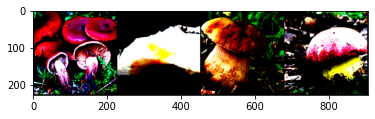

tensor(6)
tensor(6)
tensor(2)
tensor(2)


In [ ]:
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = dataiter.next()

images = images[:4]
labels = labels[:4]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
for l in labels:
    print(l)

## Training Model 2

*   The model is trained at a unit of 10 epochs
*   Default learning rate is 0.01
*   Default weight decay is 0.00005



In [ ]:
import torch.nn.functional as F
import torch.optim as optim


def train_at_lr(data, net, lr=0.01, decay=0.00005):
    net.to(device)
    epochs = 10
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=decay)
    loss = []
    for epoch in range(epochs):
        sum_loss = 0
        num = 0
        for i, batch in enumerate(data, 0):
            x, y = batch[0].to(device), batch[1].to(device)
            
            optimizer.zero_grad()
            
            y_hat = net(x)
            curr_loss = loss_func(y_hat, y)
            curr_loss.backward()
            optimizer.step()
            
            sum_loss += curr_loss.item()
            num += 1
        print(sum_loss/num)
        loss.append(sum_loss)
    return loss

* 50 epochs in total
* For every 10 epochs: learning rate decreases to 1/10 of the previous learning rate.


In [ ]:
def train(net, decay1 = 0.01):
  losses = train_at_lr(trainloader, net, decay = decay1)
  losses += train_at_lr(trainloader, net, lr = 0.001, decay = decay1)
  losses += train_at_lr(trainloader, net, lr = 0.0001, decay = decay1)
  losses += train_at_lr(trainloader, net, lr = 0.00001, decay = decay1)
  losses += train_at_lr(trainloader, net, lr = 0.000001, decay = decay1)
  return losses

def find_accur(data, net):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in data:
          x, y = batch[0].to(device), batch[1].to(device)
          y_hat = net(x)
          _, predicted = torch.max(y_hat.data, 1)
          total += y.size(0)
          correct += (predicted == y).sum().item()
  return correct / total


## Model 2
* Using pretrained network: resnet18
* Output of the network: 512


---


* Added in 2 additional layers:


> * Layer 1: 
>> * input: 512
>> * output: 60
>> * activation: ReLU

> * Layer 2:
>> * input: 60
>> * output: 9
>> * Linear Layer






---



* Trained the layer with weight decay = 0.00005


1.5164487200478713
0.908471322307984
0.7762639013429483
0.7319338272015253
0.695476030309995
0.6375331444044908
0.6218157441665729
0.5657664543638626
0.6856197950740656
0.5626361221075058
0.46961272445817787
0.4591356310993433
0.4436929387350877
0.4467054319878419
0.4467321652919054
0.44028393365442753
0.42781767559548217
0.42346282365421456
0.4098478698482116
0.4137646518647671
0.4017889729390542
0.4032705631107092
0.3952913625786702
0.39656557453175384
0.39371437455217045
0.3955665829901894
0.39881827558080357
0.39318442593018216
0.3889689141263564
0.390085111061732
0.3841855439047019
0.3883814016977946
0.38683244803299505
0.3919428853938977
0.38948825808862847
0.39158280193805695
0.38403100830813247
0.3824349706992507
0.38206588476896286
0.3892771899700165
0.3895237669348717
0.39332734669248265
0.3810679397235314
0.38473892336090404
0.3878390205403169
0.3891071130832036
0.3833144512027502
0.38621261312315863
0.3832512212296327
0.3894813371201356
Train Accuracy:  0.867593512082092
Te

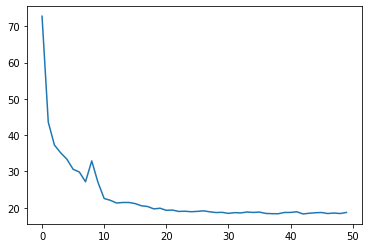

In [ ]:
import random
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.eval()
#256 : 90/76
#40  : 80/75
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(512, 60),
    nn.ReLU(),
    nn.Linear(60, 9)
    )
losses = train(model, decay1=0.00005)
acc_train = find_accur(trainloader, model)
acc_test = find_accur(testloader, model)
plt.plot(losses)
#print("Parameters: ", H1, " ", H2, " ", H3, " ", H4)
print("Train Accuracy: ", acc_train)
print("Test Accuracy: ", acc_test)

